# Welcome  

Notebook Author: Samuel Alter  
Notebook Subject: Capstone Project - Geographic Analysis

BrainStation Winter 2023: Data Science

## Introduction

This notebook works through an analysis of geographic data (i.e., elevation and aspect) - looking at its influence on wildfire incidence. We want to see if these features of the landscape can accurately predict when a wildfire will be more likely. The location of study for this project are the Santa Monica Mountains, an east-west trending mountain range.

The dataset consists of a high-density grid that has elevation and aspect data appended to each point. Also added to each point is whether there was a wildfire in that location. The elevation and aspect data are sourced from [USGS EarthExplorer](https://earthexplorer.usgs.gov), using the SRTM elevation dataset. The wildfire data is sourced from the [National Interagency Fire Center](https://data-nifc.opendata.arcgis.com/datasets/nifc::interagencyfireperimeterhistory-all-years-view/explore?location=39.778749%2C-121.769073%2C11.96). 

This notebook uses the .csv written in the final step from the Perimeters file. The .csv has already been cleaned and ready for further processing and modeling.

Please refer to the visualization notebook to see maps of the field site.

## Initial Setup

### Imports

In [319]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [320]:
# import geographic information .CSV

df_original=pd.read_csv('/Users/sra/Desktop/Data_Science_2023/_capstone/00_capstone_data/shapefiles/joins/layer_combine.csv')
df_original

,elevation,aspect,fire
0,52.0,14.743560,1
1,45.0,21.037510,1
2,45.0,333.434967,1
3,51.0,283.392487,1
4,63.0,229.289154,1
...,...,...,...
19831,22.0,270.000000,0
19832,18.0,59.036243,0
19833,20.0,264.805573,0
19834,17.0,63.434952,0


##### Convert aspect, which is a continuous variable, into a categorical.

First, rename columns.

In [321]:
# rename columns
sm_geo=df_original.copy()

In [322]:
sm_geo['asp_cont']=sm_geo['aspect']

sm_geo['elev_cont']=sm_geo['elevation']

sm_geo

,elevation,aspect,fire,asp_cont,elev_cont
0,52.0,14.743560,1,14.743560,52.0
1,45.0,21.037510,1,21.037510,45.0
2,45.0,333.434967,1,333.434967,45.0
3,51.0,283.392487,1,283.392487,51.0
4,63.0,229.289154,1,229.289154,63.0
...,...,...,...,...,...
19831,22.0,270.000000,0,270.000000,22.0
19832,18.0,59.036243,0,59.036243,18.0
19833,20.0,264.805573,0,264.805573,20.0
19834,17.0,63.434952,0,63.434952,17.0


In [323]:
def degToCompass(num):
    '''
    From https://stackoverflow.com/questions/\
    7490660/converting-wind-direction-in-angles-to-text-words
    
    Takes a value between 0 and 360 and 
    outputs the corresponding compass representation
    '''
    val=int((num/22.5)+.5)
    arr=["N","NNE","NE","ENE","E","ESE", "SE", "SSE","S","SSW","SW","WSW","W","WNW","NW","NNW"]
    return arr[(val % 16)]

degToCompass(355)

'N'

In [324]:
sm_geo['asp_cont']

0         14.743560
1         21.037510
2        333.434967
3        283.392487
4        229.289154
            ...    
19831    270.000000
19832     59.036243
19833    264.805573
19834     63.434952
19835    320.710602
Name: asp_cont, Length: 19836, dtype: float64

In [325]:
# `.apply` the function degToCompass
# to each row in the column thusly:
sm_geo['asp_cat']=sm_geo['asp_cont'].apply(degToCompass)
sm_geo

,elevation,aspect,fire,asp_cont,elev_cont,asp_cat
0,52.0,14.743560,1,14.743560,52.0,NNE
1,45.0,21.037510,1,21.037510,45.0,NNE
2,45.0,333.434967,1,333.434967,45.0,NNW
3,51.0,283.392487,1,283.392487,51.0,WNW
4,63.0,229.289154,1,229.289154,63.0,SW
...,...,...,...,...,...,...
19831,22.0,270.000000,0,270.000000,22.0,W
19832,18.0,59.036243,0,59.036243,18.0,ENE
19833,20.0,264.805573,0,264.805573,20.0,W
19834,17.0,63.434952,0,63.434952,17.0,ENE


In [326]:
sm_geo['asp_cat'].value_counts()

SSE    1717
S      1675
SSW    1468
N      1426
NNE    1394
SE     1318
NNW    1268
NE     1213
SW     1201
ESE    1158
NW     1122
ENE    1066
WSW    1025
E      1002
WNW     895
W       888
Name: asp_cat, dtype: int64

##### Convert elevation, which is a continuous variable, into a categorical.

First, rename columns.

In [327]:
# rename columns

sm_geo['elev_cont']=sm_geo['elevation']
sm_geo=sm_geo.rename({'elevation':'elev_cat'},axis=1)

sm_geo=sm_geo[['asp_cont','asp_cat','elev_cont','elev_cat','fire']]
sm_geo.head(1)

,asp_cont,asp_cat,elev_cont,elev_cat,fire
0,14.74356,NNE,52.0,52.0,1


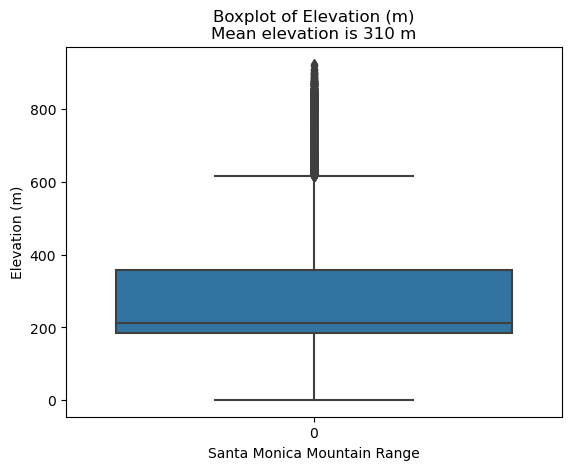

count    19836.000000
mean       281.611867
std        203.469005
min          1.000000
25%        185.000000
50%        212.000000
75%        357.000000
max        924.000000
Name: elev_cont, dtype: float64

In [328]:
chart=sns.boxplot(data=sm_geo['elev_cont'])
chart.set_title('Boxplot of Elevation (m)\nMean elevation is 310 m')
chart.set_ylabel('Elevation (m)')
chart.set_xlabel('Santa Monica Mountain Range')
plt.show()

sm_geo['elev_cont'].describe()

In [329]:
sm_geo.shape

(19836, 5)

I will categorize the elevation into four quartiles:
* $0-25\%$
* $25-50\%$
* $50-75\%$
* $>75\%$

In [330]:
def elevCategorizer(df_col):
    '''
    Hard-codes elevation bins into:
    
    low, medium, high, very high
    1-185, 185-212, 212-357, 357-924
    '''
    
    if df_col <= 185:
        return 'low'
    elif df_col <= 212:
        return 'med'
    elif df_col <= 357:
        return 'high'
    else:
        return 'vhigh'
        
elevCategorizer(450)

'vhigh'

In [331]:
# `.apply` the function elevCategorizer
# to each row in the column thusly:
sm_geo['elev_cat']=sm_geo['elev_cont'].apply(elevCategorizer)
sm_geo

,asp_cont,asp_cat,elev_cont,elev_cat,fire
0,14.743560,NNE,52.0,low,1
1,21.037510,NNE,45.0,low,1
2,333.434967,NNW,45.0,low,1
3,283.392487,WNW,51.0,low,1
4,229.289154,SW,63.0,low,1
...,...,...,...,...,...
19831,270.000000,W,22.0,low,0
19832,59.036243,ENE,18.0,low,0
19833,264.805573,W,20.0,low,0
19834,63.434952,ENE,17.0,low,0


In [332]:
sm_geo['elev_cat'].value_counts()

low      5051
high     4960
vhigh    4952
med      4873
Name: elev_cat, dtype: int64

The spread in elevation as binned by quartiles is very even.

## Prepare data for analysis

#### `get_dummies` on the `asp_cat` column

In [333]:
sm_geo_aspCat=pd.get_dummies(data=sm_geo['asp_cat'])
sm_geo_aspCat

,E,ENE,ESE,N,NE,NNE,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW
0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19831,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
19832,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
19833,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
19834,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [334]:
# add binarized columns back to dataframe
sm_geo=pd.concat([sm_geo,sm_geo_aspCat],axis=1)
sm_geo

,asp_cont,asp_cat,elev_cont,elev_cat,fire,E,ENE,ESE,N,NE,...,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW
0,14.743560,NNE,52.0,low,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,21.037510,NNE,45.0,low,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,333.434967,NNW,45.0,low,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,283.392487,WNW,51.0,low,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,229.289154,SW,63.0,low,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19831,270.000000,W,22.0,low,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
19832,59.036243,ENE,18.0,low,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19833,264.805573,W,20.0,low,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
19834,63.434952,ENE,17.0,low,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### `get_dummies` on the `elev_cat` column

In [335]:
# dummies
sm_geo_elevCat=pd.get_dummies(data=sm_geo['elev_cat'])

# add binarized columns back to dataframe
sm_geo=pd.concat([sm_geo,sm_geo_elevCat],axis=1)

# # reset axis
# sm_geo=sm_geo.reset_index()

# sm_geo=sm_geo.drop(labels=['index','elev_cat','asp_cat'],axis=1)

sm_geo

,asp_cont,asp_cat,elev_cont,elev_cat,fire,E,ENE,ESE,N,NE,...,SSE,SSW,SW,W,WNW,WSW,high,low,med,vhigh
0,14.743560,NNE,52.0,low,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,21.037510,NNE,45.0,low,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,333.434967,NNW,45.0,low,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,283.392487,WNW,51.0,low,1,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4,229.289154,SW,63.0,low,1,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19831,270.000000,W,22.0,low,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
19832,59.036243,ENE,18.0,low,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
19833,264.805573,W,20.0,low,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
19834,63.434952,ENE,17.0,low,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [336]:
# define X and y

droppedcols=['fire','asp_cat','elev_cat']

cols=[col for col in sm_geo.columns if col not in droppedcols]

X=sm_geo[cols]
y=sm_geo[['fire']]

X

,asp_cont,elev_cont,E,ENE,ESE,N,NE,NNE,NNW,NW,...,SSE,SSW,SW,W,WNW,WSW,high,low,med,vhigh
0,14.743560,52.0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1,21.037510,45.0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,333.434967,45.0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
3,283.392487,51.0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4,229.289154,63.0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19831,270.000000,22.0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
19832,59.036243,18.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
19833,264.805573,20.0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
19834,63.434952,17.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [337]:
print(X.shape)
print(y.shape)

(19836, 22)
(19836, 1)


In [338]:
# reshape the y data into a 1D array for sklearn modeling

y_array=np.ravel(a=y,order='C')
y_array.shape

(19836,)

In [339]:
y.mean()

fire    0.5
dtype: float64

The dataset has $50{\%}$ of the landscape enduring a wildfire.

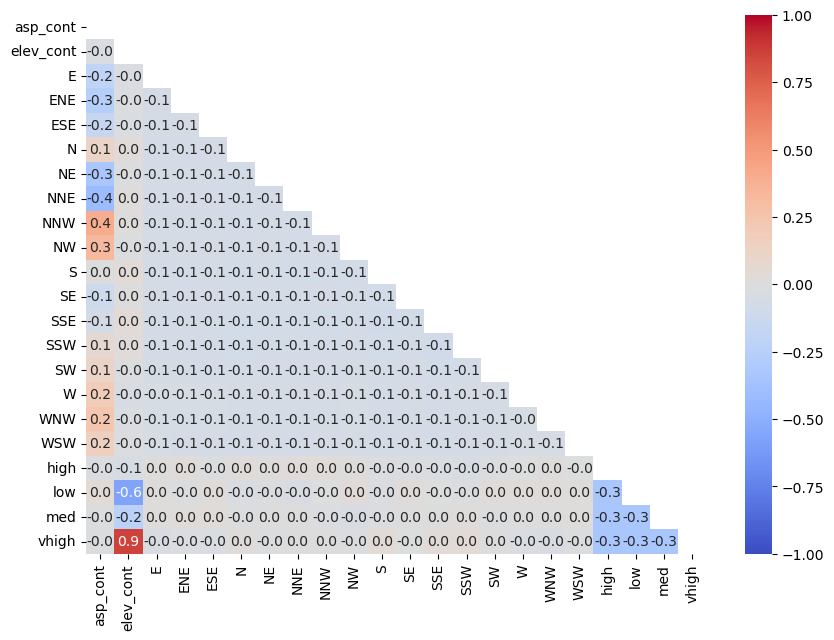

In [340]:
plt.figure(figsize=(10,7))
mask=np.triu(np.ones_like(X.corr(),dtype=bool))
sns.heatmap(data=X.corr(),
            annot=True, 
            fmt='.1f',
            cmap='coolwarm',
            vmin=-1,vmax=1,
            mask=mask)
plt.show()

There is no collinearity between aspect and elevation. Any collinearity between aspect bins and `asp_cont` is soley because aspects of `NW` and `NNW` are the highest aspect values (i.e., closest to 360 degrees). Same is true for `elev_cont`: `low` and `vhigh` elevations are negatively and positively correlated with the continuous elevation column, which is to be expected.

## Modeling

### Basic logistic regression:

#### `statsmodels`:

In [341]:
# add constant to prepare for statsmodels

X_withconstant=sm.add_constant(X)
X_withconstant.head()

,const,asp_cont,elev_cont,E,ENE,ESE,N,NE,NNE,NNW,...,SSE,SSW,SW,W,WNW,WSW,high,low,med,vhigh
0,1.0,14.743560,52.0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
1,1.0,21.037510,45.0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,1.0,333.434967,45.0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
3,1.0,283.392487,51.0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4,1.0,229.289154,63.0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0


In [342]:
X_withconstant_binary=X_withconstant.drop(['asp_cont','elev_cont'],axis=1)

In [343]:
X_withconstant_binary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19836 entries, 0 to 19835
Data columns (total 21 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   const   19836 non-null  float64
 1   E       19836 non-null  uint8  
 2   ENE     19836 non-null  uint8  
 3   ESE     19836 non-null  uint8  
 4   N       19836 non-null  uint8  
 5   NE      19836 non-null  uint8  
 6   NNE     19836 non-null  uint8  
 7   NNW     19836 non-null  uint8  
 8   NW      19836 non-null  uint8  
 9   S       19836 non-null  uint8  
 10  SE      19836 non-null  uint8  
 11  SSE     19836 non-null  uint8  
 12  SSW     19836 non-null  uint8  
 13  SW      19836 non-null  uint8  
 14  W       19836 non-null  uint8  
 15  WNW     19836 non-null  uint8  
 16  WSW     19836 non-null  uint8  
 17  high    19836 non-null  uint8  
 18  low     19836 non-null  uint8  
 19  med     19836 non-null  uint8  
 20  vhigh   19836 non-null  uint8  
dtypes: float64(1), uint8(20)
memory usa

In [344]:
# instantiate model with binary variables
logreg_sm_binary=sm.Logit(y,X_withconstant_binary)

# fit the model
logreg_sm_binary_results=logreg_sm_binary.fit()

# summary
logreg_sm_binary_results.summary()

         Current function value: 0.392162
         Iterations: 35


/Applications/Anaconda/anaconda3/envs/sklearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   fire   No. Observations:                19836
Model:                          Logit   Df Residuals:                    19815
Method:                           MLE   Df Model:                           20
Date:                Sun, 02 Apr 2023   Pseudo R-squ.:                  0.4342
Time:                        16:28:05   Log-Likelihood:                -7778.9
converged:                      False   LL-Null:                       -13749.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.2459   1.06e+06   4.01e-06      1.000   -2.08e+06    2.08e+06
E              0.0080        nan        nan        nan         nan         nan
ENE           -0.3151        nan        nan        nan         nan         nan
ESE            0.2545        nan        nan        nan         nan         nan
N             -0.1392        nan        nan        nan         nan         nan
NE            -0.1336        nan        nan        nan         nan         nan
NNE           -0.3634        nan        nan        nan         nan         nan
NNW            0.1848        nan        nan        nan         nan         nan
NW             0.2605        nan        nan        nan         nan         nan
S              0.5473        nan        nan        nan         nan         nan
SE             0.5808        nan        nan        nan         nan         nan
SSE            0.6654        nan        nan        nan         nan         nan
SSW            0.4230        nan        nan        nan         nan         nan
SW             0.6864        nan        nan        nan         nan         nan
W              0.5569        nan        nan        nan         nan         nan
WNW            0.5065        nan        nan        nan         nan         nan
WSW            0.5233        nan        nan        nan         nan         nan
high          -4.0447   4.69e+05  -8.63e-06      1.000   -9.18e+05    9.18e+05
low           -5.4211   4.69e+05  -1.16e-05      1.000   -9.18e+05    9.18e+05
med           -6.8216   4.69e+05  -1.46e-05      1.000   -9.18e+05    9.18e+05
vhigh         20.5334   4.69e+05   4.38e-05      1.000   -9.18e+05    9.18e+05
==============================================================================

Possibly complete quasi-separation: A fraction 0.25 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [345]:
# make the results from the statsmodels logistic regresion
# into a dataframe to compare betas.
# make sure to raise e to the beta to convert to odds

results=logreg_sm_binary_results.params
col_names=list(X_withconstant_binary.columns)
col_vals=[]

for i in range(len(results)):
    col_vals.append(results[i])
    
results_=list(zip(col_names,col_vals))
results_df=pd.DataFrame(results_,columns=['beta_name','beta_logOdds'])

results_df['beta_odds']=results_df['beta_logOdds'].apply(np.exp)
results_df=results_df.sort_values('beta_odds',ascending=False)
results_df=results_df.reset_index()
results_df=results_df.drop(labels=['index'],axis=1)

results_df

,beta_name,beta_logOdds,beta_odds
0,vhigh,20.533403,8.270729e+08
1,const,4.245909,6.981923e+01
2,SW,0.686418,1.986586e+00
3,SSE,0.665405,1.945279e+00
4,SE,0.580836,1.787531e+00
5,W,0.556941,1.745326e+00
6,S,0.547266,1.728521e+00
7,WSW,0.523252,1.687506e+00
8,WNW,0.506515,1.659498e+00
9,SSW,0.422976,1.526498e+00


Using the binary columns, being at very high elevations and facing south or west give the highest probability of a fire occurring. However, the p-value is very high, so this result is not significant.

What if I run the model only with the continuous variables?

In [346]:
# run model with only continuous variables

droppedcols=['E','ENE','ESE','N','NE','NNE','NNW','NW','S','SE','SSE','SSW','SW','W','WNW','WSW','high','low','med','vhigh']

cols=[col for col in X_withconstant.columns if col not in droppedcols]

X_withconstant_continuous=X_withconstant[cols]

# instantiate model
logreg_sm_cont=sm.Logit(y,X_withconstant_continuous)

# fit the model
logreg_sm_cont_results=logreg_sm_cont.fit()

# summary
logreg_sm_cont_results.summary()

Optimization terminated successfully.
         Current function value: 0.430444
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   fire   No. Observations:                19836
Model:                          Logit   Df Residuals:                    19833
Method:                           MLE   Df Model:                            2
Date:                Sun, 02 Apr 2023   Pseudo R-squ.:                  0.3790
Time:                        16:28:05   Log-Likelihood:                -8538.3
converged:                       True   LL-Null:                       -13749.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.8086      0.070    -54.583      0.000      -3.945      -3.672
asp_cont       0.0014      0.000      7.645      0.000       0.001       0.002
elev_cont      0.0146      0.000     56.863      0.000       0.014       0.015
==============================================================================
"""

In [347]:
# make the results from the statsmodels logistic regresion
# into a dataframe to compare betas.
# make sure to raise e to the beta to convert to odds

results=logreg_sm_cont_results.params
col_names=list(X_withconstant_continuous.columns)
col_vals=[]

for i in range(len(results)):
    col_vals.append(results[i])
    
results_=list(zip(col_names,col_vals))
results_df=pd.DataFrame(results_,columns=['beta_name','beta_logOdds'])

results_df['beta_odds']=results_df['beta_logOdds'].apply(np.exp)
results_df=results_df.sort_values('beta_odds',ascending=False)
results_df=results_df.reset_index()
results_df=results_df.drop(labels=['index'],axis=1)

results_df

,beta_name,beta_logOdds,beta_odds
0,elev_cont,0.014582,1.014689
1,asp_cont,0.001374,1.001375
2,const,-3.808561,0.022180


With a beta_odds of 1, there is no discernible, significant effect of elevation or aspect towards the incidence of a fire.

#### `sklearn`:

##### Train, Test, Split

Partition dataset to have $0.\overline3$ of the total as testing.

In [348]:
X.shape

(19836, 22)

In [349]:
y_array.shape

(19836,)

In [350]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y_array, test_size=(1/3),stratify=y)

In [351]:
print(f'''
X_train shape: {X_train.shape}\n
y_train shape: {y_train.shape}\n
X_test shape: {X_test.shape}\n
y_test shape: {y_test.shape}
''')


X_train shape: (13224, 22)

y_train shape: (13224,)

X_test shape: (6612, 22)

y_test shape: (6612,)



##### Basic `sklearn` `LogisticRegression`

In [352]:
# instantiate model
logreg=LogisticRegression(max_iter=10000)

# fit the model
logreg.fit(X_train,y_train)

print('Training Score: ',logreg.score(X_train,y_train))
print('Testing Score:  ',logreg.score(X_test,y_test))

Training Score:  0.8222171808832426
Testing Score:   0.8138233514821537


Good match with the training set, though the accuracy is lower than I'd like. It's great to see that the accuracy is a lot higher than the base rate of $50\%$. I'll need to scale the data too.

In [353]:
from sklearn.preprocessing import StandardScaler

# add scaler
scaler=StandardScaler()

# fit scaler on train
scaler.fit(X_train)

# transform train data
X_scaled_train=scaler.transform(X_train)
X_scaled_test=scaler.transform(X_test)

# apply scaled data to logreg model
logreg_scaled = LogisticRegression(C=1,
                                   solver='lbfgs',
                                   max_iter=10000)\
.fit(X_scaled_train, y_train)

print('Training Score: ',logreg_scaled.score(X_scaled_train,y_train))
print('Testing Score:  ',logreg_scaled.score(X_scaled_test,y_test))

Training Score:  0.8223684210526315
Testing Score:   0.8141258318209317


After applying a scaler, the training and test score remained the same. The scaling would only work on the continuous elevation and aspect columns, since the others are binary.

Let's play around with the hyperparameters to see if the accuracy is higher at a particular value.

First, let's create a validation set from the training set. We'll aim for 80% of our data be relegated towards training and validation, and 20% being relegated towards testing.

In [354]:
print(f'There are {sm_geo.shape[0]} rows in the dataset')

There are 19836 rows in the dataset


In [355]:
testing_size=0.2
val_size=0.3

In [356]:
X_remainder, X_test, y_remainder, y_test = \
    train_test_split(X.values, y_array, 
                     test_size = testing_size,stratify=y)

X_train, X_validation, y_train, y_validation = \
    train_test_split(X_remainder, y_remainder, 
                     test_size = val_size,stratify=y_remainder)

print(f'Shape of test set:       {X_test.shape}')
print(f'Shape of validation set: {X_validation.shape}')
print(f'Shape of train set:      {X_train.shape}')

Shape of test set:       (3968, 22)
Shape of validation set: (4761, 22)
Shape of train set:      (11107, 22)


Test different C values:

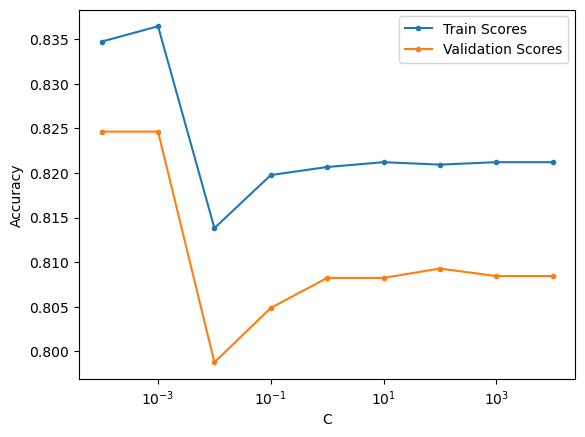

In [357]:
C_range=np.logspace(-4,4,9)

validation_scores=[]
train_scores=[]

for c in C_range:
    tuning_logreg=LogisticRegression(C=c,max_iter=10000)
    tuning_logreg.fit(X_train,y_train)
    
    # train on traning set
    train_scores.\
    append(tuning_logreg.score(X_train,y_train))
    # score on validation set
    validation_scores.\
    append(tuning_logreg.score(X_validation,y_validation))

plt.figure()
plt.plot(C_range, train_scores,label="Train Scores",marker='.')
plt.plot(C_range, validation_scores,label="Validation Scores",marker='.')
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

It looks like When $C=10^{-3}$, we get the best accuracy for the lowest spread between validation and training.

We get better accuracy than the basic model, but that's not good enough. Now let's try to increase the accuracy of our model with a grid search. We want to find the best possible accuracy. Let's try to break $90\%$!

In [358]:
X_train.shape

(11107, 22)

In [359]:
y_train.shape

(11107,)

### Grid Search

In [360]:
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

estimators = [('normalise', None),
              ('model', None)]#,
              # ('pca',None)]

pipe = Pipeline(estimators)

param_grid = [
            {'model': [LogisticRegression(max_iter=10000)],
             'model': [LogisticRegression(max_iter=10000,penalty='l1',solver='liblinear'),
                       LogisticRegression(max_iter=10000,penalty='l2')],
             'normalise': [StandardScaler(), None],
             'model__C': np.logspace(-4,4,21)}#,
             # 'pca': ['passthrough',PCA()]}
]

grid = GridSearchCV(pipe, 
                    param_grid, 
                    cv=5,
                    verbose=3,
                    n_jobs=7,
                    scoring="f1_weighted")

fittedgrid = grid.fit(X_train, y_train)

Fitting 5 folds for each of 84 candidates, totalling 420 fits


In [361]:
fittedgrid.best_estimator_

Pipeline(steps=[('normalise', None),
                ('model',
                 LogisticRegression(C=0.001584893192461114, max_iter=10000))])

In [362]:
fittedgrid.best_params_

{'model': LogisticRegression(C=0.001584893192461114, max_iter=10000),
 'model__C': 0.001584893192461114,
 'normalise': None}

In [363]:
fittedgrid.score(X_test,y_test)

0.8387134216115881

#### Grid Search, second round

Using a `GridSearchCV` on a smaller hyperparameter space to see if we can increase the accuracy even more. I will add a random forest and naive bayes to the grid search to incorporate those models. This is because random forests usually perform quite well. Naive bayes may result in a higher accuracy. We will also attempt some boosting models.

##### First, run basic versions of the models

In [377]:
# random forest

In [375]:
from sklearn.ensemble import RandomForestClassifier
from mlxtend.plotting import plot_decision_regions
from sklearn.svm import SVC

In [376]:
random_forest_model = RandomForestClassifier(n_estimators=50 )
random_forest_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50)

In [374]:
# score on random forest

# Instantiate lists to save scores in
decision_tree_train_scores = []
decision_tree_test_scores = []
# For each tree, score on train and test
for sub_tree in random_forest_model.estimators_:
    decision_tree_train_scores.append(sub_tree.score(X_train, y_train))
    decision_tree_test_scores.append(sub_tree.score(X_test, y_test))

# Rather than many separate print() statements, we can combine them into one using triple quotes.
print(f"""
Performance on fitted data:
Average Decision Tree: {np.mean(decision_tree_train_scores)}
Random Forest: {random_forest_model.score(X_train, y_train)}
----------------
Performance on test data:
Average Decision Tree: {np.mean(decision_tree_test_scores)}
Random Forest: {random_forest_model.score(X_test, y_test)}
""")


Performance on fitted data:
Average Decision Tree: 0.9529233816512109
Random Forest: 0.9967588007562799
----------------
Performance on test data:
Average Decision Tree: 0.8724949596774194
Random Forest: 0.8883568548387096



In [397]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# evaluate base model
y_pred = random_forest_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.91      0.89      1984
           1       0.90      0.87      0.89      1984

    accuracy                           0.89      3968
   macro avg       0.89      0.89      0.89      3968
weighted avg       0.89      0.89      0.89      3968



The random forest showed the highest accuracy yet!

In [378]:
# naive bayes

In [383]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

In [394]:
# models
nbmodel_bern = BernoulliNB()
nbmodel_bern.fit(X_train,y_train)
print("Bernoulli (train): --",nbmodel_bern.score(X_train,y_train))
print("Bernoulli (test): ---",nbmodel_bern.score(X_test,y_test))
nbmodel_gauss = GaussianNB()
nbmodel_gauss.fit(X_train,y_train)
print("Gauss (train): ------",nbmodel_gauss.score(X_train,y_train))
print("Gauss (test): -------",nbmodel_gauss.score(X_test,y_test))
nbmodel_multi = MultinomialNB()
nbmodel_multi.fit(X_train,y_train)
print("Multinomial (train):-",nbmodel_multi.score(X_train,y_train))
print("Multinomial (test): -",nbmodel_multi.score(X_test,y_test))

Bernoulli (train): -- 0.8022868461330692
Bernoulli (test): --- 0.8044354838709677
Gauss (train): ------ 0.7641127217070316
Gauss (test): ------- 0.7714213709677419
Multinomial (train):- 0.6831727739263528
Multinomial (test): - 0.7018649193548387


These do not perform as well as the random forest, let alone the first grid search.

Let's try some boosting-type models.

In [411]:
# Boosting

In [410]:
# AdaBoost

In [401]:
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

from sklearn.ensemble import AdaBoostClassifier

# fitting AdaBoost model with 2 estimators
abc_2 = AdaBoostClassifier(n_estimators=2)
abc_2.fit(X_train_scale, y_train)

# define base estimator with max_depth=2
from sklearn.tree import DecisionTreeClassifier
base_tree = DecisionTreeClassifier(max_depth=2)

# fit the base decision tree as a benchmark
base_tree.fit(X_train_scale, y_train)

# evaluate base model
y_pred = base_tree.predict(X_test_scale)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.94      0.86      1984
           1       0.92      0.76      0.83      1984

    accuracy                           0.85      3968
   macro avg       0.86      0.85      0.84      3968
weighted avg       0.86      0.85      0.84      3968



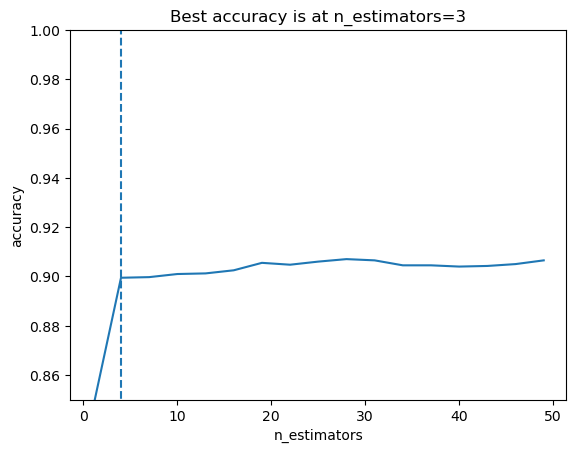

              precision    recall  f1-score   support

           0       0.89      0.93      0.91      1984
           1       0.93      0.88      0.90      1984

    accuracy                           0.91      3968
   macro avg       0.91      0.91      0.91      3968
weighted avg       0.91      0.91      0.91      3968



In [408]:
estimators = list(range(1, 50, 3))

abc_scores = []
for n_est in estimators:
    abc = AdaBoostClassifier(
        estimator=base_tree, 
        n_estimators = n_est)
    
    abc.fit(X_train_scale, y_train)
    y_pred = abc.predict(X_test_scale)
    abc_scores.append(accuracy_score(y_test, y_pred))

# plot test scores and n_estimators
plt.plot(estimators, abc_scores)
plt.xlabel('n_estimators')
plt.ylabel('accuracy')
plt.ylim([0.85, 1])
plt.title('Best accuracy is at n_estimators=3')
plt.vlines(x=4,ymin=.8,ymax=1.1,linestyles='dashed')
plt.show()

print(classification_report(y_test, y_pred))

A result of $90\%$, finally!

What about gradient boosting?

In [412]:
from sklearn.ensemble import GradientBoostingClassifier

gbc_2 = GradientBoostingClassifier()
gbc_2.fit(X_train_scale, y_train)

y_pred = gbc_2.predict(X_test_scale)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.94      0.91      1984
           1       0.93      0.87      0.90      1984

    accuracy                           0.90      3968
   macro avg       0.91      0.90      0.90      3968
weighted avg       0.91      0.90      0.90      3968



In [415]:
gbc = GradientBoostingClassifier()

parameters = {
    'loss': ['log_loss', 'exponential'],
    'learning_rate': [0.001, 0.1, 1, 10],
    'n_estimators': [100, 150, 180, 200]
}
grid_search_gbc = GridSearchCV(gbc, parameters, cv = 5, n_jobs = 7, verbose = 3)
grid_search_gbc.fit(X_train_scale, y_train)

# best score
print(f"best score: {grid_search_gbc.best_score_}")

# best parameters 
print(f"best parameters: {grid_search_gbc.best_params_}")

Fitting 5 folds for each of 32 candidates, totalling 160 fits
best score: 0.9133872279618778
best parameters: {'learning_rate': 1, 'loss': 'exponential', 'n_estimators': 180}


$91\%$!

In [416]:
# XGBoost

In [418]:
from xgboost import XGBClassifier

xgbc = XGBClassifier()
xgbc.fit(X_train_scale, y_train)

y_pred = xgbc.predict(X_test_scale)
print(classification_report(y_test, y_pred))

ModuleNotFoundError: No module named 'xgboost'

## Stacking